## Downloading data

Source: https://scop2.mrc-lmb.cam.ac.uk/download 

The following code downloads data and saves it to repositroty data folder.

In [2]:
import requests

In [17]:
urls = ['https://scop2.mrc-lmb.cam.ac.uk/files/scop-cla-latest.txt',
       'https://scop2.mrc-lmb.cam.ac.uk/files/scop-des-latest.txt',
       'https://scop2.mrc-lmb.cam.ac.uk/files/scop_fa_represeq_lib20210227.fa',
       'https://scop2.mrc-lmb.cam.ac.uk/files/scop_sf_represeq_lib20210227.fa']
filenames = ['scop-classes-raw.txt', 'scop-des-latest.txt', 
            'scop_fa_represeq.fa', 'scop_sf_represeq']
for i in range(4):
    r = requests.get(urls[i], allow_redirects=True)
    file= open('./../data/' + filenames[i], 'wb')
    file.write(r.content)
    file.close()

File scop-cla-latest.txt contains unnecessary header that must be deleted.

In [23]:
scop_classes_raw = open('./../data/' + filenames[0], 'r')
lines = scop_classes_raw.readlines()
scop_classes_raw.close()
scop_classes_transformed = open('./../data/scop-classes.txt', 'w')
scop_classes_transformed.write(lines[5][2:])
for i in range(6, len(lines)):
    scop_classes_transformed.write(lines[i])
scop_classes_transformed.close()

## Data preprocessing

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [53]:
classes_df = pd.read_csv('./../data/scop-classes.txt', delimiter = " ")

In [54]:
classes_df.head()

,FA-DOMID,FA-PDBID,FA-PDBREG,FA-UNIID,FA-UNIREG,SF-DOMID,SF-PDBID,SF-PDBREG,SF-UNIID,SF-UNIREG,SCOPCLA
0,8045703,3H8D,C:1143-1264,Q64331,1143-1264,8091604,3H8D,C:1143-1264,Q64331,1143-1264,"TP=1,CL=1000003,CF=2001470,SF=3002524,FA=4004627"
1,8094330,6J56,A:1158-1282,Q9UM54,1167-1291,8094331,6J56,A:1158-1282,Q9UM54,1167-1291,"TP=1,CL=1000003,CF=2001470,SF=3002524,FA=4004627"
2,8017835,3FKQ,A:1-116,D0VX10,1-116,8017836,3FKQ,A:1-116,D0VX10,1-116,"TP=1,CL=1000002,CF=2000016,SF=3001156,FA=4003986"
3,8021315,1XHF,A:2-122,P0A9Q1,2-122,8033695,1XHF,A:2-122,P0A9Q1,2-122,"TP=1,CL=1000002,CF=2000016,SF=3001156,FA=4003632"
4,8021787,1Y7P,B:79-215,O28869,79-215,8034167,1Y7P,B:79-215,O28869,79-215,"TP=1,CL=1000002,CF=2000016,SF=3001156,FA=4002481"


Classification file contains a lot of irrelevant information. For this research we need only FA-DOMID and SCOPCLA.CF fields. 

In [55]:
classes_df = classes_df.loc[:, ["FA-DOMID", "SCOPCLA"]]
classes_df['FOLD-RAW']=classes_df['SCOPCLA'].str.extract(r'.*CF=(\d+).*')
classes_df = classes_df.drop("SCOPCLA", axis = 1)
classes_df.head()

,FA-DOMID,FOLD-RAW
0,8045703,2001470
1,8094330,2001470
2,8017835,2000016
3,8021315,2000016
4,8021787,2000016


In [60]:
le = preprocessing.LabelEncoder()
folds = le.fit_transform(classes_df["FOLD-RAW"])
classes_df["FOLD"] = folds
classes_df.head()

,FA-DOMID,FOLD-RAW,FOLD
0,8045703,2001470,1400
1,8094330,2001470,1400
2,8017835,2000016,11
3,8021315,2000016,11
4,8021787,2000016,11


In [61]:
print("There are {} known folds".format(np.unique(folds).size))

There are 1517 known folds


In [73]:
scop_fa_rep_raw = open('./../data/' + filenames[2], 'r')
fa_lines = scop_fa_rep_raw.readlines()
scop_fa_rep_raw.close()

In [91]:
def parse_representation_file(filename):
    '''
    Returns data extracted from .fa representation file.

            Parameters:
                    filename (str): Name of the file

            Returns:
                    df (pd.DataFrame): Extracted data
    '''
    scop_fa_rep_raw = open(filename, 'r')
    fa_lines = scop_fa_rep_raw.readlines()
    scop_fa_rep_raw.close()
    assert(len(fa_lines) % 2 == 0), "WRONG FILE REPRESENTATION"
    info = fa_lines[::2]
    sequences = fa_lines[1::2]

    data = {'info': info,
            'sequence': sequences
            }
    df = pd.DataFrame(data, columns = ['info', 'sequence'])
    df['id']=df['info'].str.extract(r'>(\d+).*')
    return df.drop("info", axis = 1)


In [93]:
sequences = parse_representation_file('./../data/' + filenames[2])
sequences.head()

,sequence,id
0,NERILLVDDDYSLLNTLKRNLSFDFEVTTCESGPEALACIKKSDPF...,8072807
1,SKPRGINYDTGIPFNVLIVDDSVFTVKQLTQIFTSEGFNIIDTAAD...,8072797
2,TDETAFLNSLFMDFTSENELELFLKSLDEVWSEDLYSRLSAAGLIR...,8022848
3,PTNPLTLIVATTPIPTREKTLLGIGLNGTLPWPRIKADMSFFARVT...,8097333
4,DWGTLQTILGGVNKHSTSIGKIWLTVLFIFRIMILVVAAKEVWGDE...,8047374


## Data visualization

There are more than 1.5k known folds. Here we visualize their distribution.

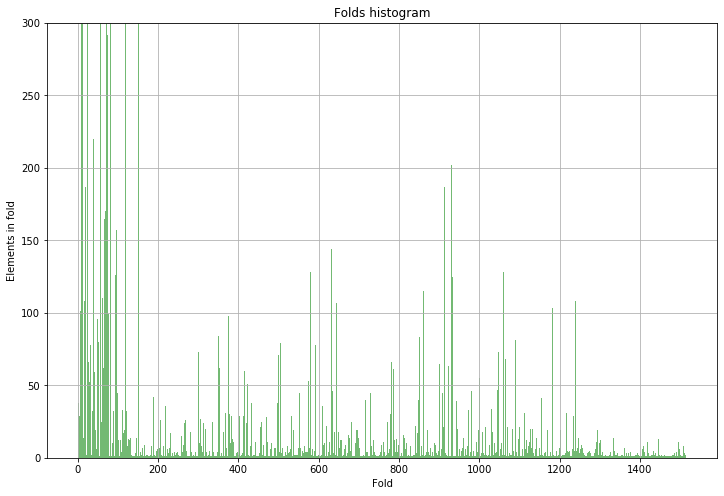

In [72]:
plt.figure(figsize = (12, 8))
plt.hist(folds, bins = 1517, density=False, facecolor='green', alpha=0.55)

plt.xlabel('Fold')
plt.ylabel('Elements in fold')
plt.title('Folds histogram')
plt.grid(True)
plt.ylim([0, 300])
plt.show()

*Conclusion:* most of the folds have less than 25 elements in them, and in  rare cases the number of elements exceeds 150. 